In [ ]:
#| default_exp clip_plot

In [ ]:
#| hide

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports and setup

### Unconditional imports

In [ ]:
#| export

# print separately that we're loading dependencies, as this can take a while
# and we want to give immediate feedback the program is starting
from clip_plot.utils import timestamp
print(timestamp(), "Beginning to load dependencies")

2025-11-01 22:25:24.729925: Beginning to load dependencies


In [ ]:
#|export

from fastcore.all import in_ipython
from tqdm.auto import tqdm

from clip_plot.from_tables import cat_tables, table_to_meta
from clip_plot.web_config import copy_web_assets, get_clip_plot_root
from clip_plot.embeddings import get_embeddings, write_embeddings
from clip_plot.metadata import get_manifest, write_metadata
from clip_plot.images import create_atlases_and_thumbs, ImageFactory
from clip_plot.configuration import UmapSpec, ClusterSpec, ViewerOptions, ImageLoaderOptions, Cfg

In [ ]:
#| export

from shutil import rmtree
from pathlib import Path
import pandas as pd
import numpy as np


## Entry

`project_images` will kick off all the main functions for the module

In [ ]:
#| export

def _project_images(imageEngine,
                    output_dir: Path,
                    plot_id: str,
                    model: str,
                    umap_spec: UmapSpec,
                    cluster_spec: ClusterSpec,
                    viewer_opts: ViewerOptions,
                    hidden_vectors: np.ndarray | None,
):
    """
    Main method for embedding user images, projecting to 2D, and creating visualization
    It would be nice to list out the image processing steps before getting started
    """

    print(timestamp(), "Starting image processing pipeline.")

    copy_web_assets(output_dir=output_dir,
                    tagline=viewer_opts.tagline, logo=viewer_opts.logo)

    write_metadata(imageEngine)

    _, atlas_data = create_atlases_and_thumbs(imageEngine, plot_id)

    if hidden_vectors is None:
        hidden_vectors = get_embeddings(imageEngine, model_name=model)

    get_manifest(imageEngine, atlas_data, hidden_vectors,
                 plot_id=plot_id, output_dir=output_dir,
                 umap_spec=umap_spec, cluster_spec=cluster_spec
                 )
    # write_images(imageEngine)
    print(timestamp(), "Done!")

In [ ]:
#| export

def project_images_pipeline(output_dir: Path,
                            plot_id: str,
                            model: str,
                            images: list[Path] | None,
                            viewer_opts: ViewerOptions,
                            umap_spec: UmapSpec,
                            cluster_spec: ClusterSpec,
                            image_opts: ImageLoaderOptions,
                            tables: list[Path] | None = None,
                            metadata: list[Path] | None = None,
                            image_path_col: str | None = None,
                            embed_path_col: str | None = None,

                ):
                """Convert a folder of images into a clip-plot visualization"""

                if tables and images:
                        raise ValueError("Provide either tables or images parameter, not both.")
                if not tables and not images:
                        raise ValueError("Must provide tables or images")
                if tables:
                        print(timestamp(), "Loading tables")
                        table = cat_tables(tables)
                        images = list(table[image_path_col].values)
                        print(timestamp(), "Loading embeddings from disk")
                        hidden_vectors = np.array([np.load(e) for e in tqdm(table[embed_path_col])])
                else:
                        hidden_vectors = None
                        table = None

                data_dir = output_dir / "data"
                imageEngine = ImageFactory(images, data_dir, metadata,
                                           **image_opts.model_dump(),)

                # grab metadata from table if provided
                if table is not None:
                        imageEngine.meta_headers, imageEngine.metadata = table_to_meta(table)

                print(f"Config to project images: {str(image_opts.model_dump())}")

                np.random.seed(image_opts.seed) 

                _project_images(imageEngine,
                                output_dir = output_dir,
                                plot_id=plot_id,
                                model=model,
                                cluster_spec=cluster_spec,
                                umap_spec=umap_spec,
                                hidden_vectors=hidden_vectors,
                                viewer_opts=viewer_opts
                                )

### Embed images without building visualization

Outputs a table linking the embedding files to the images

Test with bash command:
```
clipplot_embed_images --images "tests/smithsonian_butterflies_10/jpgs/*.jpg" --output_dir "tests/smithsonian_butterflies_10/DELETEME_embed_only" --metadata "tests/smithsonian_butterflies_10/meta_data/good_meta.csv"
```

In [ ]:
#| export

def embed_images_pipeline(images: list[Path],
                     model: str,
                     metadata: list[Path] | None,
                     output_dir: Path,
                     table_format: str,
                     table_id: str,
                ):
                "Embed a folder of images and save embeddings as .npy file to disk"
                output_dir = Path(output_dir)

                # using Path.cwd() to handle ../ names -- not sure if this is superstitious
                data_dir = Path.cwd() / output_dir.resolve() / "data"

                imageEngine = ImageFactory(image_paths=images, data_dir=data_dir, metadata_paths=metadata)

                embeddings = get_embeddings(imageEngine, model_name=model)

                def _model_shortname(n: str) -> str:
                        return "__".join(n.split("/")[-2:])

                embs_dir = data_dir/f"embeddings_{_model_shortname(model)}"
                embs_dir.mkdir(parents=True, exist_ok=True)
                emb_paths = write_embeddings(embeddings, imageEngine.filenames, embs_dir)

                df = pd.DataFrame({"image_path": imageEngine.image_paths,
                                   "image_filename": imageEngine.filenames,
                                   "embed_path": [str(e) for e in emb_paths]})

                if len(imageEngine.metadata) > 0:
                        df_meta = pd.DataFrame(imageEngine.metadata)
                        df_meta = df_meta.rename(columns={"filename": "image_filename"})
                        # drop "image_path" column if df_meta has it
                        if "image_path" in df_meta.columns:
                                df_meta = df_meta.drop(columns=["image_path"])

                        df = df.merge(df_meta.drop_duplicates(["image_filename"]), on="image_filename")

                ## standardize sort order of table
                # put standard columns first if they exist in df
                standard_cols = pd.Index(["image_path", "image_filename", "embed_path", "category", "tags", "x", "y"])
                cols_sorted = standard_cols.intersection(df.columns)
                # append non-standard columns, sorted alphabetically
                cols_sorted = cols_sorted.append(df.columns.difference(standard_cols).sort_values())
                df = df[cols_sorted]

                if table_format == "csv":
                        df.to_csv(data_dir / f"EmbedImages__{table_id}.csv", index=False)
                else:
                        df.to_parquet(data_dir / f"EmbedImages__{table_id}.parquet", index=False)

In [ ]:
#| hide

copy_root_dir = get_clip_plot_root()

In [ ]:
#| hide

def test_butterfly():
    test_images = copy_root_dir / "tests/smithsonian_butterflies_10/jpgs/*.jpg"
    test_output_dir = copy_root_dir / "tests/smithsonian_butterflies_10/output_test_temp"
    meta = copy_root_dir / "tests/smithsonian_butterflies_10/meta_data/good_meta.csv"
    if Path(test_output_dir).exists():
        rmtree(test_output_dir)

    cfg = Cfg(paths={"images": test_images},)

    project_images_pipeline(images=cfg.paths.images,
                   output_dir=test_output_dir,
                   metadata=[meta],
                   plot_id="test_diff",
                   model=cfg.model,
                   viewer_opts = cfg.view_opts,
                   umap_spec = cfg.umap_spec,
                   cluster_spec = cfg.cluster_spec,
                   image_opts = cfg.image_opts,
                   )

    return

2025-11-01 22:25:26.775465: First three paths: /home/willsa/git/clip-plot/tests/smithsonian_butterflies_10/jpgs/30aeb051d-ee0d-4c5b-8a85-a8da7baef5fd.jpg
/home/willsa/git/clip-plot/tests/smithsonian_butterflies_10/jpgs/9fea3150-a3d4-11ed-aeea-e36f1256f233.jpg
/home/willsa/git/clip-plot/tests/smithsonian_butterflies_10/jpgs/329a4c094-8536-4396-be70-3d9b5d0744d9.jpg
2025-11-01 22:25:26.775645: Validating input images


  0%|          | 0/12 [00:00<?, ?it/s]

Config to project images: {'seed': 42, 'shuffle': False, 'cell_size': 64, 'lod_cell_height': 128, 'atlas_size': 4096}
2025-11-01 22:25:26.987342: Starting image processing pipeline.
2025-11-01 22:25:27.034105: Copying images to output directory


  0%|          | 0/12 [00:00<?, ?it/s]

Device for inference: cpu


Device set to use cpu


2025-11-01 22:25:28.553542: Creating embeddings using timm/convnext_tiny.dinov3_lvd1689m


  0%|          | 0/12 [00:00<?, ?it/s]

2025-11-01 22:25:30.289321: Done creating embeddings.
2025-11-01 22:25:30.305038: Creating multi-umap layout
2025-11-01 22:25:30.361747: Creating {label} pointgrid
2025-11-01 22:25:30.395539: Creating grid layout
2025-11-01 22:25:30.397387: Creating rasterfairy layout


/home/willsa/git/clip-plot/.venv/lib/python3.10/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/willsa/git/clip-plot/.venv/lib/python3.10/site-packages/rasterfairy/coonswarp.py:267: RuntimeWarning: invalid value encountered in divide
  density_top /= np.sum(density_top)
/home/willsa/git/clip-plot/.venv/lib/python3.10/site-packages/rasterfairy/coonswarp.py:273: RuntimeWarning: invalid value encountered in divide
  density_right /= np.sum(density_right)
/home/willsa/git/clip-plot/.venv/lib/python3.10/site-packages/rasterfairy/coonswarp.py:279: RuntimeWarning: invalid value encountered in divide
  density_bottom /= np.sum(density_bottom)
/home/willsa/git/clip-plot/.venv/lib/python3.10/site-packages/rasterfairy/coonswarp.py:285: RuntimeWarning: invalid value encountered in divide
  density_left /= np.sum(density_left)


2025-11-01 22:25:30.985074: Coonswarp rectification could not be performed data must be finite, check for nan or inf values
applying hungarian assignment for 12 indices
2025-11-01 22:25:30.988472: Creating categorical layout
2025-11-01 22:25:30.990200: Creating custom layout based on xy coordinates in metadata
2025-11-01 22:25:30.991998: Creating custom layout
2025-11-01 22:25:31.532665: Clustering data with HDBSCAN
2025-11-01 22:25:31.537180: Found 0 hotspots
{'atlas_dir': '/home/willsa/git/clip-plot/tests/smithsonian_butterflies_10/output_test_temp/data/atlases',
 'config': {'sizes': {'atlas': 4096, 'cell': 64, 'lod': 128}},
 'creation_date': '01-November-2025-22:25:31',
 'custom_hotspots': '/home/willsa/git/clip-plot/tests/smithsonian_butterflies_10/output_test_temp/data/hotspots/user_hotspots.json',
 'default_hotspots': None,
 'gzipped': False,
 'imagelist': '/home/willsa/git/clip-plot/tests/smithsonian_butterflies_10/output_test_temp/data/imagelist.json',
 'initial_layout': 'umap'

/home/willsa/git/clip-plot/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/willsa/git/clip-plot/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


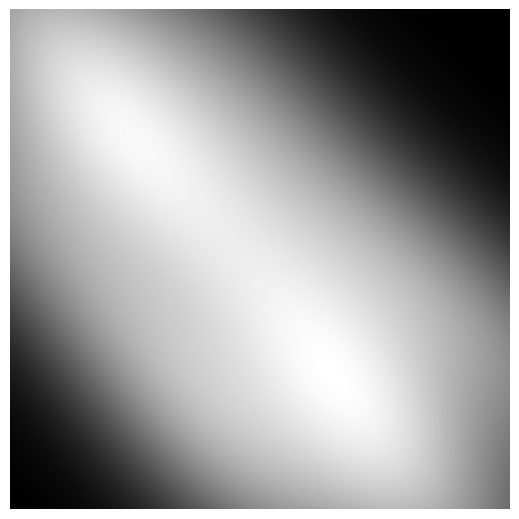

In [ ]:
#| hide

if __name__ == "__main__" and in_ipython():
    test_butterfly()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()